<a href="https://colab.research.google.com/github/37stu37/FFE/blob/master/FFE_postprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
# Load the Drive helper and mount
from google.colab import drive
%tensorflow_version 2.x
# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
%%time 
%%capture
!apt update
!apt upgrade
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes 
!pip install memory_profiler

CPU times: user 1.21 s, sys: 180 ms, total: 1.39 s
Wall time: 24.3 s


In [51]:
%%time
import datetime
import glob
import shutil
from math import sqrt
import os
import matplotlib.pyplot as plt
import bokeh
import numpy as np
import pandas as pd
import geopandas as gpd
from scipy.spatial import distance
from shapely.geometry import box
from shapely.geometry import shape
from shapely.geometry import Point
import networkx as nx
from sys import getsizeof
from numba import jit
import dask.dataframe as dd
import dask.array as da
import dask
from dask.distributed import Client
from dask.diagnostics import ProgressBar
%matplotlib inline
%load_ext memory_profiler

pd.options.mode.chained_assignment = None  # default='warn'

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler
CPU times: user 2.12 ms, sys: 1e+03 ns, total: 2.12 ms
Wall time: 1.89 ms


In [52]:
client = Client(processes=False)
client

/usr/local/lib/python3.6/dist-packages/distributed/bokeh/core.py:57: UserWarning: 
Failed to start diagnostics server on port 8787. [Errno 99] Cannot assign requested address
  warnings.warn('\n' + msg)
/usr/local/lib/python3.6/dist-packages/distributed/deploy/local.py:197: UserWarning: 
Could not launch service 'bokeh' on port 8787. Got the following message:

[Errno 99] Cannot assign requested address
  self.scheduler.start(scheduler_address)


Client Scheduler: inproc://172.28.0.2/120/8,Cluster Workers: 1 Cores: 2 Memory: 13.66 GB


In [0]:
path = '/content/drive/My Drive/05_Sync/FFE/FireNetwork/00_input'
path_output = '/content/drive/My Drive/05_Sync/FFE/FireNetwork/00_output'

In [0]:
# @dask.delayed
def read_and_concatenate_parquets(prefix, path=path_output):
  L = []
  files = glob.glob(os.path.join(path_output, prefix))# output_scenario_0_step_0.parquet
  for file in files:
    pqt = dd.read_parquet(file)
    L.append(pqt)
  df = dd.concat(L)
  return df

In [0]:
def count_fid_occurences(df):
  count = df.groupby(['source'])['count'].sum().compute()
  count_df = count.to_frame()
  return count_df

In [0]:
def load_shapefile(file_name, minx, miny, maxx, maxy):
    # crop data
    bbox = box(minx, miny, maxx, maxy)
    # building point dataset
    gdf_buildings = gpd.read_file(os.path.join(path, file_name), bbox=bbox)
    max_extent = gdf_buildings.total_bounds
    data_size = getsizeof(gdf_buildings) /(1024.0**3)
    print("Shapefile extent : {}".format(max_extent))
    print("Asset loaded : {}".format(len(gdf_buildings)))
    # gdf.plot(column='IgnProb_bl', cmap='hsv', legend=True)
    return gdf_buildings

In [0]:
def merge_coordinates_export_shape(ddf, gdf, name_output):
  gdf = gdf[['TARGET_FID', 'geometry']]
  df = pd.DataFrame(gdf)
  # ddf = ddf.compute()
  df_merge = ddf.merge(df, how='left', left_on='source', right_on='TARGET_FID')
  gdf_merge = gpd.GeoDataFrame(df_merge, geometry='geometry')
  gdf_merge.plot(column='count', cmap='seismic', legend=True)
  gdf_merge.to_file(os.path.join(path_output, "shapefiles", name_output + ".shp"))
  return gdf_merge

In [0]:
%%time
%memit
df = read_and_concatenate_parquets("output_scenario*")
count_df = count_fid_occurences(df)

In [59]:
gdf = load_shapefile("buildings_raw.shp", 1740508, 5420049, 1755776, 5443033) # whole

Shapefile extent : [1740507.1581502  5420048.34765005 1755776.95354986 5443033.48509979]
Asset loaded : 74245


peak memory: 740.03 MiB, increment: 0.33 MiB
CPU times: user 41.4 s, sys: 4.07 s, total: 45.4 s
Wall time: 54.5 s


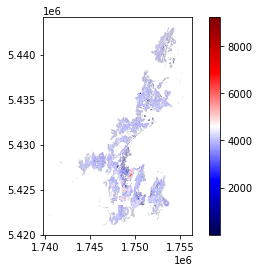

In [60]:
%%time
%memit
gdf_count = merge_coordinates_export_shape(count_df, gdf, "burned_buildings")